In [1]:
import numpy as np

import matplotlib.pyplot as plt
import glob

from numba import njit, vectorize, float32

from typing import Callable, Optional

import hoomd
import gsd.hoomd

from matplotlib import cm, colors

import sys

In [2]:
from monk import nb
from monk import prep
from monk import pair
import freud

# Equilibration time in the liquid state

With the KA LJ system, I'm noticing that it takes approximately 200 $\tau$ for the system thermostat to equilibrate sufficiently

### Params
* $N$ = 32768
* $kT$ = 1.0
* $dt$ = 0.0025
* $\tau$ = 0.25

In [25]:
device = hoomd.device.GPU()
seed = 3412
sim = hoomd.Simulation(device, seed=seed)

N = 32768
rng = prep.init_rng(seed + 1)
L = prep.len_from_phi(N, 1.2, dim=3)
snap = prep.approx_euclidean_snapshot(N, L, rng, dim=3, ratios=[80,20], diams=[1.0, 0.88])

sim.create_state_from_snapshot(snap)

integrator = hoomd.md.Integrator(dt=0.0025)
tree = hoomd.md.nlist.Tree(0.3)
lj = pair.KA_LJ(tree)
nvt = hoomd.md.methods.NVT(hoomd.filter.All(), 1.0, 0.25)
integrator.forces = [lj]
integrator.methods = [nvt]

sim.always_compute_pressure = True
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All())
sim.operations.computes.append(thermodynamic_properties)

sim.operations.integrator = integrator

sim.run(0)

nvt.thermalize_thermostat_dof()

sim.run(0)

log = hoomd.logging.Logger(categories=["scalar"])
log.add(thermodynamic_properties)

writer = hoomd.write.GSD(
    trigger=hoomd.trigger.Periodic(10),
    filename=f"_equil-from-lattice-log_temp-1.0_.gsd",
    mode="wb",
    filter=hoomd.filter.Null(),
    # dynamic=["property", "momentum"],
    log=log
)
sim.operations.writers.append(writer)

sim.run(40_000, True)

In [26]:
gsd_log = gsd.hoomd.open("_equil-from-lattice-log_temp-1.0_.gsd")

In [37]:
kinetic_temp = []
tstep = []
start = 0
length = len(gsd_log)
for i in range(start, start+length):
    snap = gsd_log[i]
    kinetic_temp.append(snap.log["md/compute/ThermodynamicQuantities/kinetic_temperature"][0])
    tstep.append(snap.configuration.step)

In [38]:
len(tstep)

4001

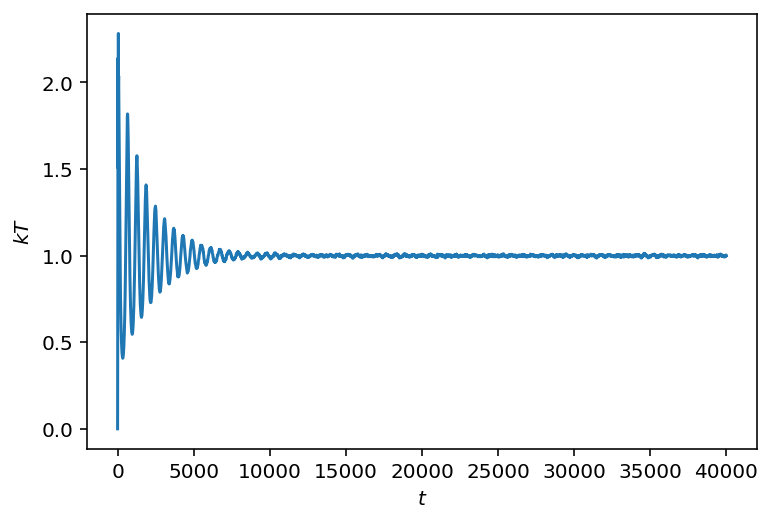

In [44]:
plt.plot(tstep, kinetic_temp)
plt.ylabel(r"$kT$")
plt.xlabel(r"$t$");

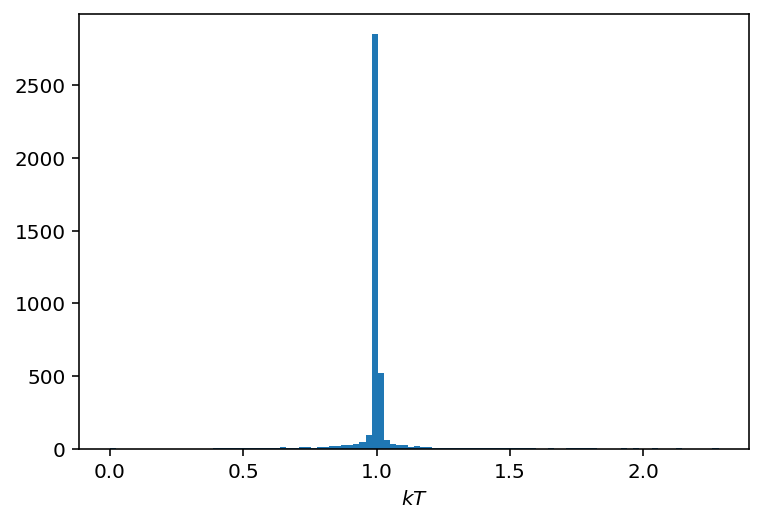

In [43]:
plt.hist(kinetic_temp, bins=100);
plt.xlabel(r"$kT$");

In [47]:
hoomd.write.GSD.write(sim.state, "_equil-state_temp-1.0_.gsd")
del sim

# Max timesteps w/ temperature

In [77]:
device = hoomd.device.GPU()
seed = 3412
sim = hoomd.Simulation(device, seed=seed)
sim.create_state_from_gsd("_equil-state_temp-1.0_.gsd")

dt = 0.0025
kT = 1.0

integrator = hoomd.md.Integrator(dt=dt)
tree = hoomd.md.nlist.Tree(0.3)
lj = pair.KA_LJ(tree)
nvt = hoomd.md.methods.NVT(hoomd.filter.All(), kT, 0.25)
integrator.forces = [lj]
integrator.methods = [nvt]

sim.always_compute_pressure = True
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All())
sim.operations.computes.append(thermodynamic_properties)

sim.operations.integrator = integrator

log = hoomd.logging.Logger(categories=["scalar"])
log.add(thermodynamic_properties)

writer = hoomd.write.GSD(
    trigger=hoomd.trigger.Periodic(10),
    filename=f"_test-stability_temp-{kT}_dt-{dt}_.gsd",
    mode="wb",
    filter=hoomd.filter.Null(),
    # dynamic=["property", "momentum"],
    log=log
)
sim.operations.writers.append(writer)

sim.run(10_000, True)

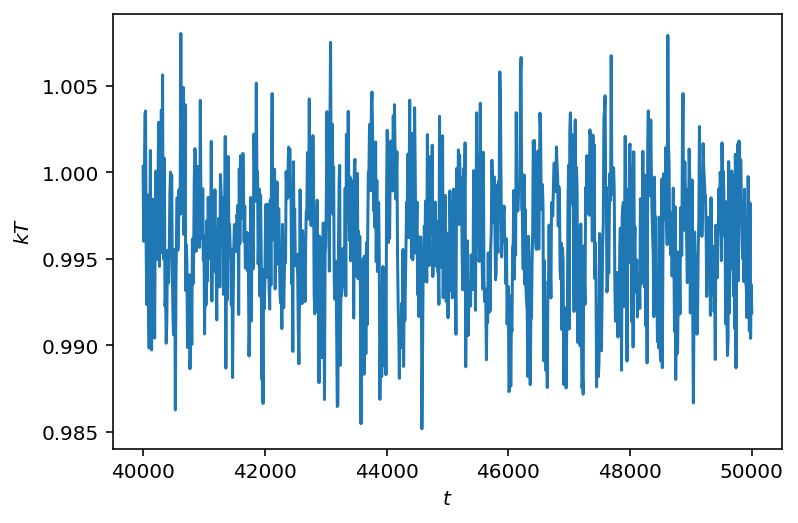

In [86]:
gsd_log = gsd.hoomd.open("_test-stability_temp-1.0_dt-0.005_.gsd")
kinetic_temp = []
tstep = []
start = 0
length = len(gsd_log)
for i in range(start, start+length):
    snap = gsd_log[i]
    kinetic_temp.append(snap.log["md/compute/ThermodynamicQuantities/kinetic_temperature"][0])
    tstep.append(snap.configuration.step)

plt.plot(tstep, kinetic_temp)
plt.ylabel(r"$kT$")
plt.xlabel(r"$t$");

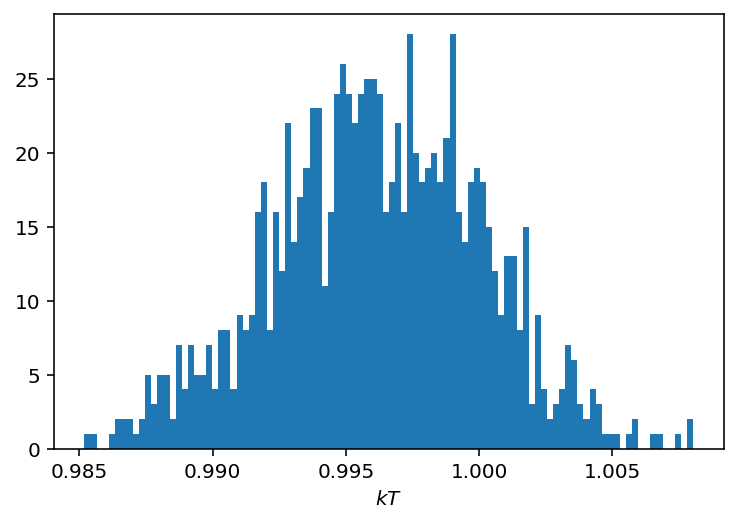

In [87]:
plt.hist(kinetic_temp, bins=100);
plt.xlabel(r"$kT$");

### Note

So one key thing that can be observed when we increase the timestep too much is that the kinetic temperature deviates
from that set by the thermostat

In [89]:
print(np.mean(kinetic_temp), "+/-", np.std(kinetic_temp))

0.9961658050032225 +/- 0.003914875930129362


# Thermostat equil. @ some temps 

In [90]:
device = hoomd.device.GPU()
seed = 3412
sim = hoomd.Simulation(device, seed=seed)
sim.create_state_from_gsd("_equil-state_temp-1.0_.gsd")

dt = 0.0025
kT = 0.5

integrator = hoomd.md.Integrator(dt=dt)
tree = hoomd.md.nlist.Tree(0.3)
lj = pair.KA_LJ(tree)
nvt = hoomd.md.methods.NVT(hoomd.filter.All(), kT, 0.25)
integrator.forces = [lj]
integrator.methods = [nvt]

sim.always_compute_pressure = True
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All())
sim.operations.computes.append(thermodynamic_properties)

sim.operations.integrator = integrator

log = hoomd.logging.Logger(categories=["scalar"])
log.add(thermodynamic_properties)

writer = hoomd.write.GSD(
    trigger=hoomd.trigger.Periodic(10),
    filename=f"_partial-equil-log_temp-{kT}_.gsd",
    mode="wb",
    filter=hoomd.filter.Null(),
    # dynamic=["property", "momentum"],
    log=log
)
sim.operations.writers.append(writer)

sim.run(40_000, True)

In [94]:
hoomd.write.GSD.write(sim.state, f"_partial-equil-state_temp-{kT}_.gsd")

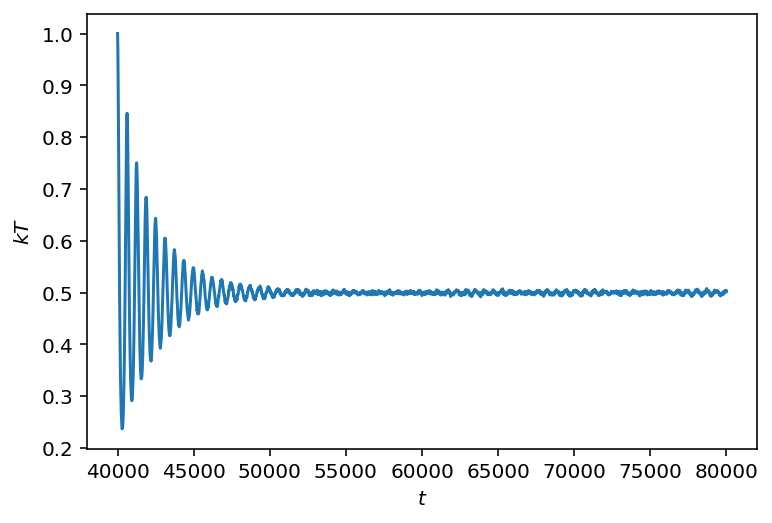

In [93]:
gsd_log = gsd.hoomd.open("_partial-equil-log_temp-0.5_.gsd")
kinetic_temp = []
tstep = []
start = 0
length = len(gsd_log)
for i in range(start, start+length):
    snap = gsd_log[i]
    kinetic_temp.append(snap.log["md/compute/ThermodynamicQuantities/kinetic_temperature"][0])
    tstep.append(snap.configuration.step)

plt.plot(tstep, kinetic_temp)
plt.ylabel(r"$kT$")
plt.xlabel(r"$t$");

# Max timestep from other temperature

In [104]:
device = hoomd.device.GPU()
seed = 3412
sim = hoomd.Simulation(device, seed=seed)

dt = 0.001
kT = 0.5

sim.create_state_from_gsd(f"_partial-equil-state_temp-{kT}_.gsd")

integrator = hoomd.md.Integrator(dt=dt)
tree = hoomd.md.nlist.Tree(0.3)
lj = pair.KA_LJ(tree)
nvt = hoomd.md.methods.NVT(hoomd.filter.All(), kT, 0.01)
integrator.forces = [lj]
integrator.methods = [nvt]

sim.always_compute_pressure = True
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All())
sim.operations.computes.append(thermodynamic_properties)

sim.operations.integrator = integrator

log = hoomd.logging.Logger(categories=["scalar"])
log.add(thermodynamic_properties)

writer = hoomd.write.GSD(
    trigger=hoomd.trigger.Periodic(10),
    filename=f"_partial-equil-sc-log_temp-{kT}_.gsd",
    mode="wb",
    filter=hoomd.filter.Null(),
    # dynamic=["property", "momentum"],
    log=log
)
sim.operations.writers.append(writer)

sim.run(5_000, True)

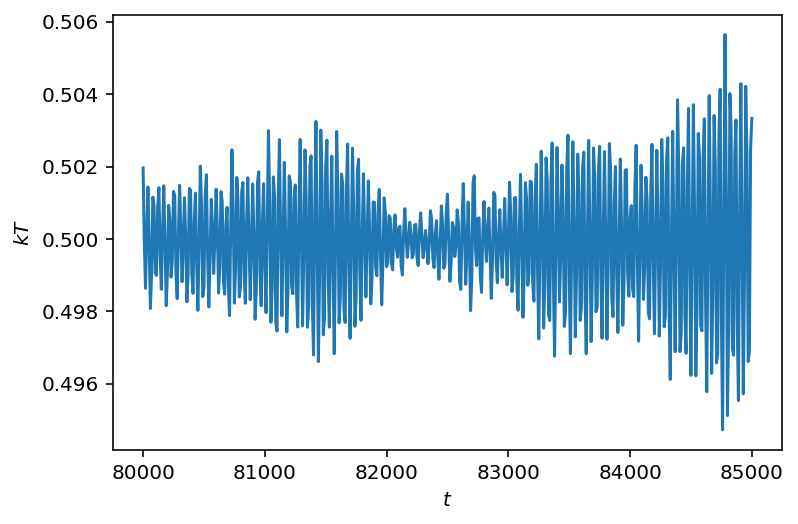

In [105]:
gsd_log = gsd.hoomd.open("_partial-equil-sc-log_temp-0.5_.gsd")
kinetic_temp = []
tstep = []
start = 0
length = len(gsd_log)
for i in range(start, start+length):
    snap = gsd_log[i]
    kinetic_temp.append(snap.log["md/compute/ThermodynamicQuantities/kinetic_temperature"][0])
    tstep.append(snap.configuration.step)

plt.plot(tstep, kinetic_temp)
plt.ylabel(r"$kT$")
plt.xlabel(r"$t$");

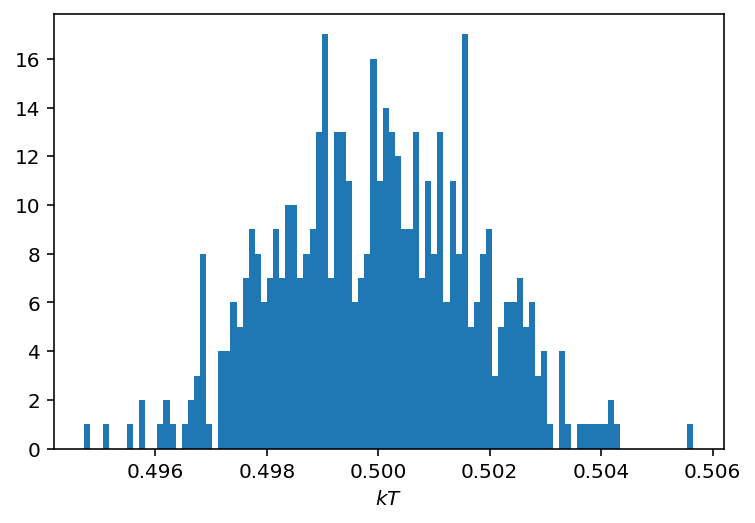

In [106]:
plt.hist(kinetic_temp, bins=100);
plt.xlabel(r"$kT$");

In [107]:
print(np.mean(kinetic_temp), "+/-", np.std(kinetic_temp))

0.49994969527873895 +/- 0.0017679180117271957
